# Predicting the number of thermally accessible conformers - as computed by CREST / GFN2 across a large molecular test set

This notebook is intended to be used in JupyterLab. YMMV

In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

from scipy import constants

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

We'll read in the combined CSV, including subset name, filename, SMILES, computational entropy, and a variety of descriptors generated by RDKit

In [2]:
df = pd.read_csv("total-entropy.csv")
# drop inf and nan (i.e. some molecules from COD don't have Gasteiger charges)
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
print(len(df.index))
# 115599 molecules left
#  (technically we should check to make sure all the SMILES are unique!)

115599


In [3]:
# what do we have
print(df.columns)
df = df.astype({"NumAtoms": int, "NumBonds": int, "NumRotors": int, "NumMethyl": int, "NumAmine": int, "NumHydroxyl": int, "HDonors": int, "HAcceptors": int, "RingCount": int, "NumAromaticRings": int})
df.describe()

Index(['Category', 'File', 'SMILES', 'ConfEntropy', 'VibEntropy', 'RotEntropy',
       'TransEntropy', 'NumAtoms', 'NumBonds', 'ExactMolWt', 'Volume',
       'NumRotorsStrict', 'NumRotors', 'NumMethyl', 'NumAmine', 'NumHydroxyl',
       'HDonors', 'HAcceptors', 'RingCount', 'NumAromaticRings',
       'MaxAbsPartialChg', 'MinAbsPartialChg', 'MaxPartialChg',
       'MinPartialChg', 'TPSA', 'LabuteASA', 'MolMR', 'MolLogP', 'EState_VSA1',
       'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
       'HallKierAlpha', 'BertzCT', 'BalabanJ', 'Ipc', 'Kappa1', 'Kappa2',
       'Kappa3', 'FractionCSP3', 'NumBridgeheadAtoms', 'NumSpiroAtoms',
       'Asphericity', 'Eccentricity', 'InertialShapeFactor',
       'RadiusOfGyration', 'SpherocityIndex', 'ConfUnder1', 'ConfUnder2',
       'ConfUnder3', 'ConfUnder4', 'ConfUnder5', 'ConfUnder6', 'ECFP4',
       'ECFP6'],
      dtype='object')


,ConfEntropy,VibEntropy,RotEntropy,TransEntropy,NumAtoms,NumBonds,ExactMolWt,Volume,NumRotorsStrict,NumRotors,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,ConfUnder1,ConfUnder2,ConfUnder3,ConfUnder4,ConfUnder5,ConfUnder6
count,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,...,115599.000000,115599.000000,115599.000000,1.155990e+05,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000
mean,34.600737,396.587555,149.397586,182.867627,28.846954,31.686105,403.960759,312.795836,4.585844,5.305349,...,0.939662,0.000980,4.216079,1.815609e-01,6.963633,18.400851,35.212779,56.374510,80.246923,104.314319
std,12.579259,144.674773,8.564845,4.143806,9.175250,10.688507,124.997746,94.665169,2.663472,3.052690,...,0.066122,0.002114,0.976017,1.498155e-01,11.066574,32.883641,64.505961,103.662286,146.573767,188.945147
min,0.004000,24.589368,95.997696,158.891584,4.000000,3.000000,56.026215,50.192000,0.000000,0.000000,...,0.098074,0.000012,1.231888,3.065851e-13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,26.387000,288.953316,144.527912,180.334584,22.000000,24.000000,313.073537,243.912000,3.000000,3.000000,...,0.912651,0.000315,3.533319,7.594415e-02,2.000000,3.000000,4.000000,6.000000,7.000000,8.000000
50%,36.106000,405.266424,151.004744,183.861696,30.000000,33.000000,416.107578,322.304000,4.000000,5.000000,...,0.961570,0.000554,4.156412,1.438170e-01,4.000000,8.000000,14.000000,20.000000,27.000000,33.000000
75%,43.851000,483.881692,154.966992,185.543664,34.000000,38.000000,476.114814,368.372000,6.000000,7.000000,...,0.987186,0.001016,4.830287,2.476433e-01,8.000000,20.000000,39.000000,62.000000,89.000000,117.000000
max,69.453000,1689.051512,188.941072,203.702224,128.000000,168.000000,2039.240573,1132.392000,20.000000,20.000000,...,0.999999,0.235738,12.050900,9.944582e-01,427.000000,981.000000,1469.000000,2244.000000,2997.000000,4137.000000


In this notebook, we want to know how many thermally accessble conformers are there (e.g., ConfUnder1, ConfUnder2, etc.). We'll first generate a model for ConfUnder1 and then move to 2 or 3 kcal/mol.

Here we'll start using the "strict" definition of rotatable bonds from RDKit, but we'll compare both

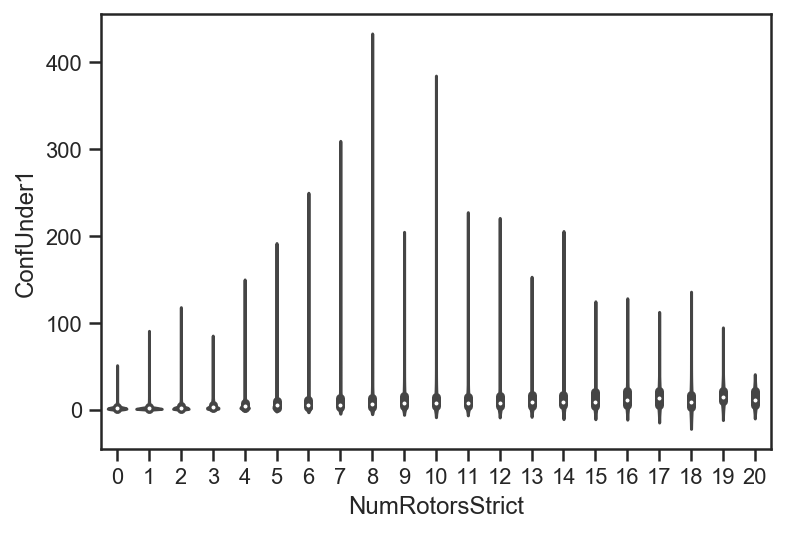

In [4]:
sns.violinplot(x="NumRotorsStrict", y="ConfUnder1", data=df)

Hard to tell, but the number of conformers might not be linear - we'll still try a linear model as a simple starting point.

In [5]:
import sklearn
from sklearn.metrics import mean_absolute_error

lm1 = ols('ConfUnder1~NumRotorsStrict', data=df).fit()
print(lm1.summary())
print('mean absolute error:', mean_absolute_error(df['ConfUnder1'], lm1.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:             ConfUnder1   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                 1.146e+04
Date:                Thu, 19 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:55:03   Log-Likelihood:            -4.3645e+05
No. Observations:              115599   AIC:                         8.729e+05
Df Residuals:                  115597   BIC:                         8.729e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.2402      0.062     

Looks like the violin plots are showing a lot of outliers - most of the compounds are well fit to a linear model with errors ~5.2 conformers. What about the looser definition of rotors?

In [6]:
lm2 = ols('ConfUnder1~NumRotors', data=df).fit()
print('mean absolute error:', mean_absolute_error(df['ConfUnder1'], lm2.fittedvalues))

mean absolute error: 5.283673430939346


About the same errors.

    - NumRotorsStrict = 5.24 conformers
    - NumRotors = 5.28 conformers

For conformational entropy, we find the number of terminal methyl groups is important, so let's check that too.

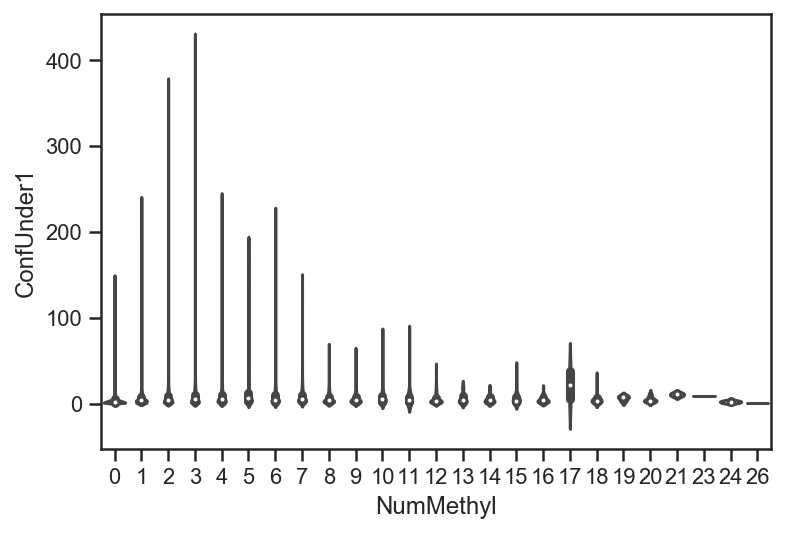

In [7]:
sns.violinplot(x="NumMethyl", y="ConfUnder1", data=df)

In [8]:
lm3 = ols('ConfUnder1~NumMethyl', data=df).fit()
print('mean absolute error:', mean_absolute_error(df['ConfUnder1'], lm3.fittedvalues))

mean absolute error: 5.72849769182629


A bit worse, but we can try using both.

In [9]:
lm4 = ols('ConfUnder1~NumRotors+NumMethyl', df).fit()
print(lm4.summary())
print('mean absolute error:', mean_absolute_error(df['ConfUnder1'], lm4.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:             ConfUnder1   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     5504.
Date:                Thu, 19 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:56:11   Log-Likelihood:            -4.3666e+05
No. Observations:              115599   AIC:                         8.733e+05
Df Residuals:                  115596   BIC:                         8.734e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0392      0.066     15.854      0.0

Maybe we should use a sub-linear form. We can test that...

In [10]:
max_mae = 10.0
best_alpha = 0
for a in range(1,150):
    alpha = float(a)/100.0
    lm = ols('ConfUnder1~np.power(NumRotors,alpha)+np.power(NumMethyl,alpha)', df).fit()
    mae = mean_absolute_error(df['ConfUnder1'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = alpha
        max_mae = mae
        print('best so far', best_alpha, max_mae)

best so far 0.01 5.672431620945898
best so far 0.02 5.670080055159583
best so far 0.03 5.658620375220916
best so far 0.04 5.638579684984759
best so far 0.05 5.612604702047294
best so far 0.06 5.584178589584349
best so far 0.07 5.554995811689227
best so far 0.08 5.526322250549971
best so far 0.09 5.503358571834371
best so far 0.1 5.4832197263109785
best so far 0.11 5.464691839579735
best so far 0.12 5.447762283745128
best so far 0.13 5.4367787035908
best so far 0.14 5.428744379432615
best so far 0.15 5.421333360586502
best so far 0.16 5.41457144724255
best so far 0.17 5.408557283896581
best so far 0.18 5.4029615492188725
best so far 0.19 5.3976180471889
best so far 0.2 5.392632244010046
best so far 0.21 5.387899498562979
best so far 0.22 5.3835365145855745
best so far 0.23 5.379184168286577
best so far 0.24 5.374906644403241
best so far 0.25 5.371327960837747
best so far 0.26 5.368002132922832
best so far 0.27 5.364740191830238
best so far 0.28 5.361457085879518
best so far 0.29 5.35816

We might as well keep log(n+1) as our pick - there's not much difference if we let it go higher.

So the current model drops the MAE down to 5.7 J/mol•K which is almost a third of the initial model
What other factors are relevant? We have to tune the formula, because some columns (descriptors) cause errors in statsmodel - likely the values have errors - but none of these are expected to be important based on chemistry intutiton anyway. 

Once we have the (large) formula, we can use LASSO or similar regularization procedures to remove factors. We'll try a range of different penalities to find one with the lowest mean absolute error.

In [11]:
max_mae = 10.0
best_alpha = 0
for a in range(1,150):
    alpha = float(a)/100.0
    lm = ols('ConfUnder1~np.power(NumRotors,alpha)', df).fit()
    mae = mean_absolute_error(df['ConfUnder1'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = alpha
        max_mae = mae
        print('best so far', best_alpha, max_mae)

best so far 0.01 5.806481227536101
best so far 0.03 5.794690774673698
best so far 0.04 5.770784582148708
best so far 0.05 5.739680717828925
best so far 0.06 5.704337525802177
best so far 0.07 5.668953507208156
best so far 0.08 5.635007007915997
best so far 0.09 5.601666244158051
best so far 0.1 5.57232892534203
best so far 0.11 5.5452417445312605
best so far 0.12 5.522114406196119
best so far 0.13 5.502573318728189
best so far 0.14 5.486424959340171
best so far 0.15 5.471712364634568
best so far 0.16 5.458189780025427
best so far 0.17 5.445785238382993
best so far 0.18 5.434143910293851
best so far 0.19 5.427111821330651
best so far 0.2 5.421555450841587
best so far 0.21 5.41733938216046
best so far 0.22 5.413268410949727
best so far 0.23 5.40933047725333
best so far 0.24 5.405429951097914
best so far 0.25 5.401552821651485
best so far 0.26 5.3977255585993245
best so far 0.27 5.393933530923288
best so far 0.28 5.390196841631777
best so far 0.29 5.386514382217011
best so far 0.3 5.38294

In [20]:
for conf in ['ConfUnder1', 'ConfUnder2', 'ConfUnder3', 'ConfUnder4', 'ConfUnder5', 'ConfUnder6']:
    max_mae = 100.0
    best_alpha = 0
    for a in range(1,200):
        alpha = float(a)/100.0
        formula = conf + '~np.power(NumRotors,alpha)'
        lm = ols(formula, df).fit()
        mae = mean_absolute_error(df[conf], lm.fittedvalues)
        if mae < max_mae:
            best_alpha = alpha
            max_mae = mae
    print(conf, ' mae: ', max_mae, ' best exponent', best_alpha)
    formula = conf + '~np.power(NumRotors,{})'.format(best_alpha)
    lm = ols(formula, df).fit()
    print(conf, 'params: ', lm.params[0], lm.params[1])

ConfUnder1  mae:  5.281102715682532  best exponent 0.85
ConfUnder1 params:  0.433265614977615 1.615557819006215
ConfUnder2  mae:  15.191525303219995  best exponent 1.2
ConfUnder2 params:  0.7494463636744851 2.2932831064814203
ConfUnder3  mae:  29.64690994193482  best exponent 1.37
ConfUnder3 params:  0.720117209909211 3.2402040081664514
ConfUnder4  mae:  47.46613404015435  best exponent 1.45
ConfUnder4 params:  -0.5520836404338572 4.579811107702897
ConfUnder5  mae:  67.23724373273478  best exponent 1.53
ConfUnder5 params:  -0.8996416328062844 5.582786463565805
ConfUnder6  mae:  86.78454897502527  best exponent 1.58
ConfUnder6 params:  -1.74411460002951 6.612114655315937


In [ ]:
formula = 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+NumAtoms+NumBonds+ExactMolWt+Volume+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+TPSA+LabuteASA+MolMR+MolLogP+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+NumBridgeheadAtoms+NumSpiroAtoms+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex'
print(formula)

In [ ]:
max_mae = 10.0
best_alpha = 0
for a in range(100):
    lm = ols(formula, df).fit_regularized(alpha=float(a)/100.0)
    mae = mean_absolute_error(df['ConfEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = float(a)/100.0
        max_mae = mae
        print('best so far', best_alpha, max_mae)

lm = ols(formula,df).fit_regularized(alpha=best_alpha)
print(lm.params)

Clearly many of these factors are removed by LASSO. We'll create a hand-tuned smaller subset of factors to compare with our initial model

In [ ]:
lm5 = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP', df).fit()
print(mean_absolute_error(df['ConfEntropy'], lm5.fittedvalues))
print(lm5.summary())

These new factors add some minor corrections, improving the mean absolute error from ~5.7 J/mol•K to ~5.5 J/mol•K. More importantly, the new model suggests that hydrogen-bonding groups change the entropy (not surprising, since intramolecular hydrogen bonds would decrease the flexibility), and a molecules with more rings tend to yield lower conformational entropy.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

In [ ]:
# simple log(rotors+1) + log(methyls + 1) model
initial_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)'), df, df.ConfEntropy, cv=5)
print(initial_score.mean(), "+/-", initial_score.std())

In [ ]:
# more complex model (with rings, hydrogen bonds, etc.)
new_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP'), df, df.ConfEntropy, cv=5)
print(new_score.mean(), "+/-", new_score.std())

We can see that the very simply log(rotors + 1) + log(methyl + 1) model is pretty good (RMSE 5.73 J/mol•K and cross-validated R^2 0.595) but the newer model improves both RMSE and cross-validated R^2.

We have two holdout sets. One is a pool of ~9000 cyclic tetrapeptides (`data/peptides-entropy.csv`), the other is a pool of ~20k molecules from ZINC run on a different resource (`data/holdout-zinc.csv`).

Let's compare how well our model does on these sets:

In [ ]:
# a set of cyclic peptides
df2 = pd.read_csv("data/peptides-entropy.csv")
# drop inf and nan
df2.replace([np.inf, -np.inf], np.nan)
df2.dropna(inplace=True)
print(len(df2.index))

In [ ]:
# the simple log(rotors + 1)+log(methy + 1) model
print("simple log+log model on peptides: ", mean_absolute_error(df2['ConfEntropy'], lm4.predict(df2)))
# The more complex model (with rings, hydrogen bonds, etc.)
print("complex model on peptides: ", mean_absolute_error(df2['ConfEntropy'], lm5.predict(df2)))

(Ironically, the simple model handles the cyclic peptides better)

In [ ]:
# the ZINC holdout set
df3 = pd.read_csv("data/holdout-zinc.csv")
# drop inf and nan
df3.replace([np.inf, -np.inf], np.nan)
df3.dropna(inplace=True)
print(len(df3.index))

In [ ]:
# the simple log(rotors + 1)+log(methy + 1) model
print("simple log+log model on ZINC holdout: ", mean_absolute_error(df3['ConfEntropy'], lm4.predict(df3)))
# The more complex model (with rings, hydrogen bonds, etc.)
print("complex model on ZINC holdout: ", mean_absolute_error(df3['ConfEntropy'], lm5.predict(df3)))

For the ZINC holdouts, the errors are about the same. Safe to say both the models give ~5 J/mol•K errors for conformational entropies.

# Regression Analysis
Let's check regression test plots (e.g. QQ plots, etc.) for the main models

In [ ]:
fig = sm.qqplot(lm4.resid, line='s') # residual QQ plot
plt.show()

In [ ]:
res_plot = plt.scatter(lm4.fittedvalues, lm4.resid)

Hmm, the residual error (y-axis) scales with fitted value - maybe it's not log(). Let's try a model with sqrt()

In [ ]:
lm6 = ols('ConfEntropy~np.sqrt(NumRotors)+np.sqrt(NumMethyl)', df).fit()
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm6.fittedvalues))

In [ ]:
fig = sm.qqplot(lm6.resid, line='s') # residual QQ plot

In [ ]:
res_plot = plt.scatter(lm6.fittedvalues, lm6.resid)

Maybe the power scaling isn't 0.5 - we can test that...

In [ ]:
max_mae = 10.0
best_alpha = 0
for a in range(1,100):
    alpha = float(a)/100.0
    lm = ols('ConfEntropy~np.power(NumRotors,alpha)+np.power(NumMethyl,alpha)', df).fit()
    mae = mean_absolute_error(df['ConfEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = alpha
        max_mae = mae
        print('best so far', best_alpha, max_mae)

Okay, so 0.5 (sqrt) looks like the best power, but doesn't improve things much. What if we add a linear term for both methyl and rotors?

In [ ]:
lm7 = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+NumRotors+NumMethyl', df).fit()
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm7.fittedvalues))

In [ ]:
fig = sm.qqplot(lm7.resid, line='s') # residual QQ plot

In [ ]:
res_plot = plt.scatter(lm7.fittedvalues, lm7.resid)

In short, we can try more flexible models - with variable exponents, but they're not really any better than log()…